In [4]:
import numpy as np
import graph_tool.all as gt
from rich import print
import random
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
from simulation_with_time_window import simulate_SIS, make_node_feature_df

Hello from cn-final-project!

100%|██████████| 1233/1233 [07:47<00:00,  2.64it/s, Infected fraction=0.124]


Text(0.5, 1.0, 'Temporal SIS epidemic simulation (undirected)')

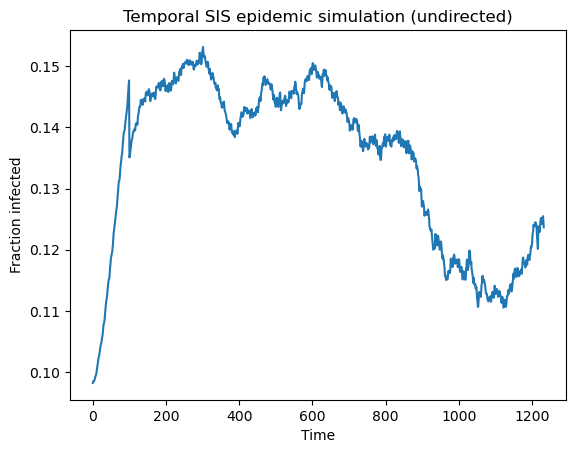

In [ ]:
random.seed(42)
print("Hello from cn-final-project!")
g = gt.collection.ns["escorts"]

sim, g = simulate_SIS(g, max_steps=150, start=1000)

plt.plot(sim)
plt.xlabel("Time")
plt.ylabel("Fraction infected")
plt.title("Temporal SIS epidemic simulation (undirected)")
# plt.savefig("plots/temporal_sis_simulation_with_time_window.png")
# plt.show()

In [23]:
df = make_node_feature_df(g)
print(df)

Computing centrality metrics...

Computed degree

Computed leverage

Computed betweenness

node  degree  leverage  betweenness  cumulative_infected
0          0      49  0.709559     0.002755                    2
1          1      24 -0.244821     0.001299                    6
2          2      39  0.407448     0.001819                    5
3          3       1 -0.920000     0.000000                    0
4          4       1 -0.960000     0.000000                    0
...      ...     ...       ...          ...                  ...
16725  16725       1 -0.333333     0.000000                    0
16726  16726       1  0.000000     0.000000                    0
16727  16727       1  0.000000     0.000000                    0
16728  16728       1  0.000000     0.000000                    0
16729  16729       1  0.000000     0.000000                    0

[16730 rows x 5 columns]

<Axes: xlabel='betweenness', ylabel='cumulative_infected'>

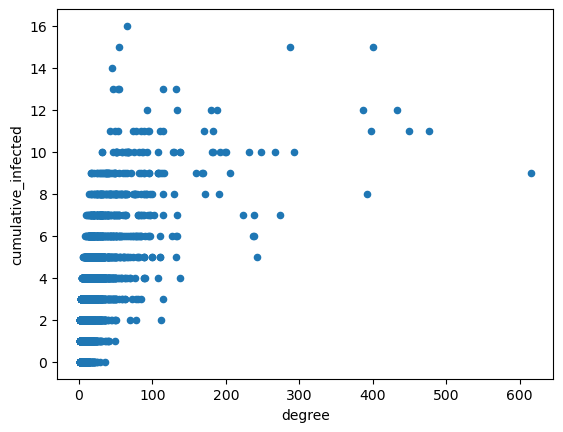

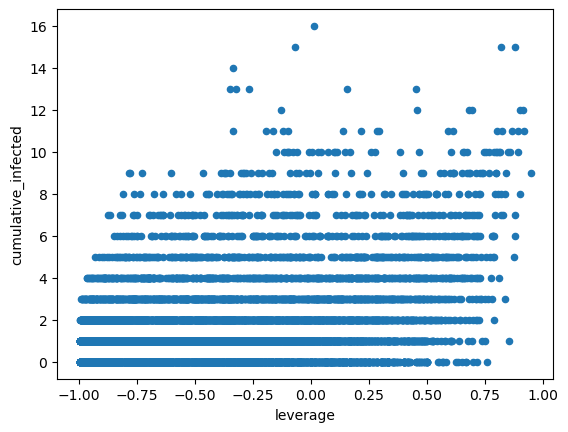

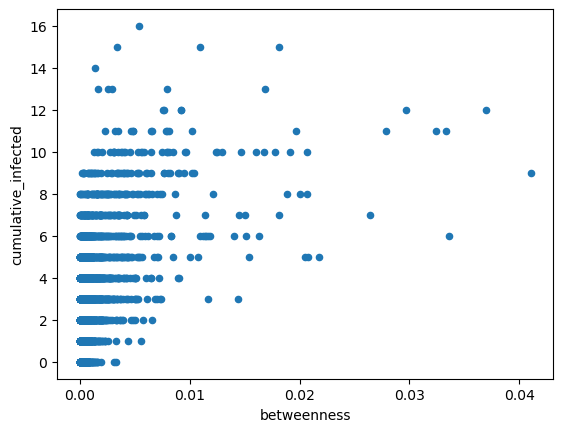

In [24]:
df.plot.scatter(x="degree", y="cumulative_infected")
df.plot.scatter(x="leverage", y="cumulative_infected")
df.plot.scatter(x="betweenness", y="cumulative_infected")


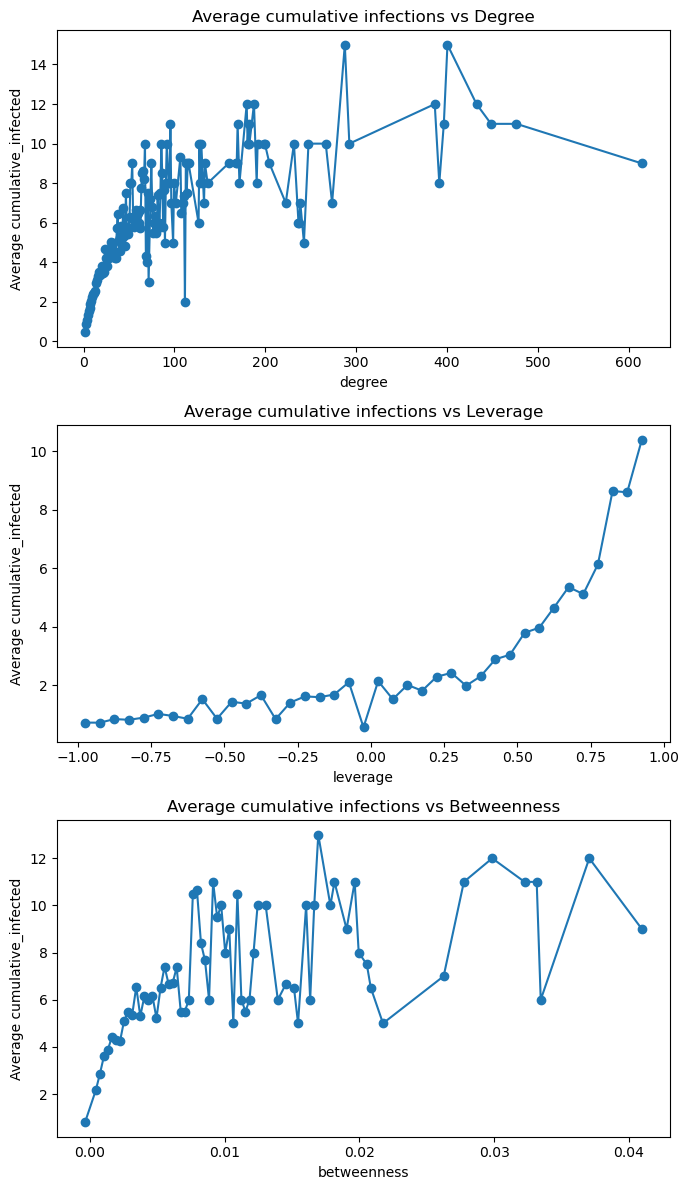

In [32]:
def binned_mean_plot(df, x_col, y_col="cumulative_infected", bin_size=None, bins=None, ax=None, title=None):
    """
    Plot the mean of y_col within bins of x_col.
    - If bins is given, it overrides bin_size.
    - If neither is given and x_col is integer-like, groups by exact value.
    - Returns the aggregated dataframe with columns: ['bin_left','bin_right','center','mean','count'].
    """
    data = df[[x_col, y_col]].dropna()

    if bins is None and bin_size is None:
        # If no binning specified, group by exact x (useful for integer degrees)
        grp = data.groupby(x_col)[y_col].agg(['mean','count']).reset_index()
        centers = grp[x_col].to_numpy()
        mean_vals = grp['mean'].to_numpy()
        counts = grp['count'].to_numpy()
        agg = pd.DataFrame({
            'bin_left': centers, 'bin_right': centers, 'center': centers,
            'mean': mean_vals, 'count': counts
        })
    else:
        if bins is None:
            xmin, xmax = data[x_col].min(), data[x_col].max()
            # nice edges covering [xmin, xmax]
            start = np.floor(xmin / bin_size) * bin_size
            stop  = np.ceil(xmax / bin_size) * bin_size + bin_size
            bins = np.arange(start, stop, bin_size)

        cut = pd.cut(data[x_col], bins=bins, include_lowest=True)
        grp = data.groupby(cut, observed=True)[y_col].agg(['mean','count'])
        # bin centers
        centers = np.array([iv.left + (iv.right - iv.left)/2 for iv in grp.index])
        mean_vals = grp['mean'].to_numpy()
        counts = grp['count'].to_numpy()
        agg = pd.DataFrame({
            'bin_left': [iv.left for iv in grp.index],
            'bin_right': [iv.right for iv in grp.index],
            'center': centers,
            'mean': mean_vals,
            'count': counts
        }).dropna(subset=['mean'])

    if ax is None:
        ax = plt.gca()
    ax.plot(agg['center'], agg['mean'], marker='o', linestyle='-')
    ax.set_xlabel(x_col)
    ax.set_ylabel(f'Average {y_col}')
    if title:
        ax.set_title(title)

    return agg

# ---------- Usage ----------
# 1) Degree (exact-by-degree or with bin_size=1)
fig, axes = plt.subplots(3, 1, figsize=(7, 12))

_ = binned_mean_plot(df, 'degree', y_col='cumulative_infected',
                     bin_size=1, ax=axes[0],
                     title='Average cumulative infections vs Degree')

# 2) Leverage (choose a bin size, e.g. 0.05)
_ = binned_mean_plot(df, 'leverage', y_col='cumulative_infected',
                     bin_size=0.05, ax=axes[1],
                     title='Average cumulative infections vs Leverage')

# 3) Betweenness (often skewed; pick a sensible bin size, or define custom bins)
# Example with custom quantile bins:
q = np.linspace(0, 1, 21)
# bw_edges = np.unique(np.quantile(df['betweenness'].dropna(), q))
_ = binned_mean_plot(df, 'betweenness', y_col='cumulative_infected',
                     bin_size=0.0003, ax=axes[2],
                     title='Average cumulative infections vs Betweenness')

plt.tight_layout()
plt.show()


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cumulative_infected_vs_properties(
    n_runs, max_steps, start, properties,
    bin_size,                 # float or dict {prop: float}
    use_ci=True,
    min_bins=2,               # ensure at least this many bins
    max_bins=1e6             # safety cap to avoid thousands of bins
):
    """
    Run n_runs SIS simulations, collect per-run node features, and plot
    cumulative_infected as a function of each property in `properties`,
    using FIXED-WIDTH bins with configurable bin_size (per property or shared).

    Args:
        n_runs (int)
        max_steps (int)
        start (int)
        properties (list[str]): exactly 3 property names
        bin_size (float or dict): width of bins. If dict, must map each prop -> width.
        use_ci (bool): if True, 95% CI over runs; else ±1 std over runs.
        min_bins (int): enforce at least this many bins
        max_bins (int): cap number of bins to avoid runaway plots

    Returns:
        results: dict[prop] = {
            "bin_edges": np.ndarray,
            "bin_centers": np.ndarray,
            "mean": np.ndarray,
            "lower": np.ndarray,
            "upper": np.ndarray,
            "per_run_bin_means": np.ndarray shape (n_runs, n_bins)
        }
    """
    assert len(properties) == 3, "Please pass exactly three property names."
    g0 = gt.collection.ns["escorts"]

    # ---- Collect DataFrames across runs ----
    frames = []
    for r in range(n_runs):
        g = g0.copy()
        _, g_out = simulate_SIS(g, max_steps=max_steps, start=start)
        print(f"simulation run {r} done")
        dfr = make_node_feature_df(g_out)
        print(f"make node features run {r} done")
        dfr["run"] = r
        frames.append(dfr)
        

    df_all = pd.concat(frames, ignore_index=True)

    required = {"cumulative_infected", *properties}
    missing = required - set(df_all.columns)
    if missing:
        raise ValueError(f"Missing columns in node features: {missing}")

    # normalize bin_size input
    if isinstance(bin_size, (int, float)):
        bin_size_map = {p: float(bin_size) for p in properties}
    elif isinstance(bin_size, dict):
        bin_size_map = {p: float(bin_size[p]) for p in properties}
    else:
        raise TypeError("bin_size must be a float or dict {prop: float}")

    results = {}
    for prop in properties:
        w = bin_size_map[prop]
        if w <= 0:
            raise ValueError(f"bin_size for {prop} must be > 0")

        # global min/max across all runs for this property
        x = df_all[prop].to_numpy()
        x = x[np.isfinite(x)]
        if x.size == 0:
            raise ValueError(f"No finite values for property '{prop}'.")

        x_min, x_max = np.min(x), np.max(x)

        # Ensure at least two bins; build edges with fixed width
        if x_max == x_min:  # constant feature: make a tiny span
            x_max = x_min + w

        # edges from min to max with step w; include the max in the last bin
        edges = np.arange(x_min, x_max + w, w, dtype=float)
        # guard: ensure last edge is strictly > last-1 for digitize behavior
        if edges.size < 2:
            edges = np.array([x_min, x_min + w], dtype=float)

        # enforce min/max bins
        n_bins = len(edges) - 1
        if n_bins < min_bins:
            # expand symmetrically to reach min_bins
            extra = min_bins - n_bins
            x_range = (min_bins * w)
            edges = np.linspace(x_min, x_min + x_range, min_bins + 1)
            n_bins = min_bins
        if n_bins > max_bins:
            raise ValueError(
                f"Too many bins for '{prop}' ({n_bins}). "
                f"Increase bin_size or raise max_bins."
            )

        # Slightly nudge the last edge to include max values with right=False
        eps = np.finfo(float).eps * max(1.0, abs(edges[-1]))
        edges[-1] += eps

        # per-run bin means to avoid run-size bias
        per_run_bin_means = np.full((n_runs, n_bins), np.nan)
        for r in range(n_runs):
            dfr = df_all[df_all["run"] == r]
            xv = dfr[prop].to_numpy()
            yv = dfr["cumulative_infected"].to_numpy()

            # bin ids in [0, n_bins-1]
            ids = np.digitize(xv, edges, right=False) - 1
            ids = np.clip(ids, 0, n_bins - 1)

            # mean per bin for this run
            for b in range(n_bins):
                vals = yv[ids == b]
                if vals.size:
                    per_run_bin_means[r, b] = np.nanmean(vals)

        # aggregate across runs
        mean = np.nanmean(per_run_bin_means, axis=0)
        std = np.nanstd(per_run_bin_means, axis=0, ddof=1)
        n_eff = np.sum(~np.isnan(per_run_bin_means), axis=0).clip(min=1)
        sem = std / np.sqrt(n_eff)
        if use_ci:
            lower, upper = mean - 1.96 * sem, mean + 1.96 * sem
            band_label = "95% CI over runs"
        else:
            lower, upper = mean - std, mean + std
            band_label = "±1 std over runs"

        centers = 0.5 * (edges[:-1] + edges[1:])

        # plot
        plt.figure()
        plt.plot(centers, mean, marker="o", label=f"Mean over {n_runs} runs")
        plt.fill_between(centers, lower, upper, alpha=0.3, label=band_label)
        plt.xlabel(prop)
        plt.ylabel("Cumulative infected")
        plt.title(f"Cumulative infected vs {prop} (bin size = {w})")
        plt.legend()

        results[prop] = {
            "bin_edges": edges,
            "bin_centers": centers,
            "mean": mean,
            "lower": lower,
            "upper": upper,
            "per_run_bin_means": per_run_bin_means,
        }

    return results


In [ ]:
bin_sizes = {
    "degree": 1.0,
    "leverage": 0.05,
    "betweenness": 0.0003,
}
res = plot_cumulative_infected_vs_properties(
    n_runs=5, max_steps=None, start=1000,
    properties=["degree", "leverage", "betweenness"],
    bin_size=bin_sizes,
    use_ci=True
)


 56%|█████▋    | 696/1233 [01:53<03:18,  2.70it/s, Infected fraction=0.143]

In [38]:
print(3>None)

TypeError: '>' not supported between instances of 'int' and 'NoneType'